# Setup

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "svm"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# SUPPORT VECTOR MACHINES

- Can perform linear / nonlinear classification, regression and even novelty detection.
- The best for small to medium sized nonlinear data sets (hundreds to thousands of instances), especially for classification.


Fitting the widest possible street between the classes aka *large margin classification*

Points that are on the street are called *support vectors*.

SVMs are sensitive to feature scales as the shape of the SVM can easily change depending on the scale of certain features.
(Review later why, from a mathematical point of view).

## Linear SVM Classification

- Hard margin classification, where ALL instances MUST be off the street and on the correct side

- Soft margin classification, where we allow instances to end up in the middle of the street or even on the wrong side (*margin violations*)


If the SVM model is overfitting, regularize it by reducing C.

In [4]:
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2) # Iris virginica

# The C hyperparameter is used to determine the size of the margin
# Lower C will allow for larger margins / having more instances supporting the street
svm_clf = make_pipeline(StandardScaler(),
                        LinearSVC(C=1, random_state=42))
svm_clf.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

In [5]:
X_new = [[5.5,1.7], [5.0, 1.5]]
svm_clf.predict(X_new)

array([ True, False])

In [6]:
svm_clf.decision_function(X_new)

array([ 0.66163816, -0.22035761])

In [7]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)


/var/folders/7j/0rhz18qs4d9dzfjkz9p2xlcr0000gn/T/ipykernel_33769/1500710550.py:25: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
/var/folders/7j/0rhz18qs4d9dzfjkz9p2xlcr0000gn/T/ipykernel_33769/1500710550.py:26: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()


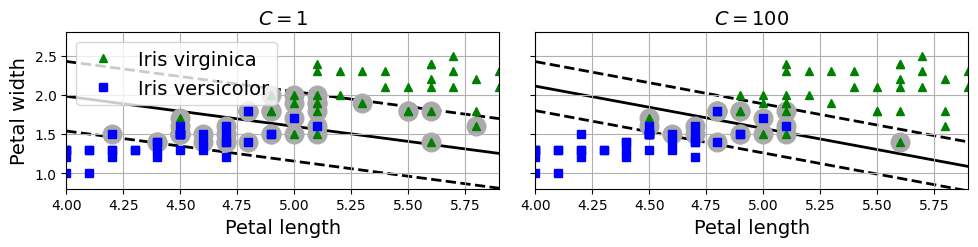

In [8]:
# extra code – this cell generates and saves Figure 5–4

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, max_iter=10_000, dual=True, random_state=42)
svm_clf2 = LinearSVC(C=100, max_iter=10_000, dual=True, random_state=42)

scaled_svm_clf1 = make_pipeline(scaler, svm_clf1)
scaled_svm_clf2 = make_pipeline(scaler, svm_clf2)

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf1.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length")
plt.title(f"$C = {svm_clf2.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

save_fig("regularization_plot")
plt.show()

# Nonlinear SVM Classification

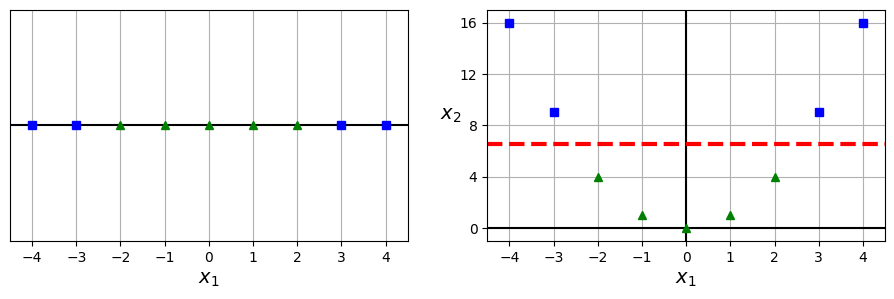

In [9]:
# extra code – this cell generates and saves Figure 5–5

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel("$x_1$")
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$  ", rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

In [10]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples = 100, noise = 0.15, random_state = 42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C = 10, max_iter= 10000, random_state=42)
)

polynomial_svm_clf.fit(X, y)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

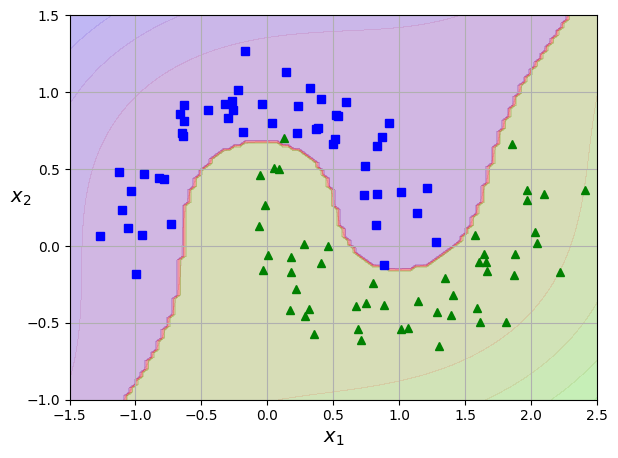

In [11]:
# extra code – this cell generates and saves Figure 5–6
import numpy as np

# function to plot the dataset
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

# function to plot the prediction
def plot_predictions(clf, axes):
    # create equally space x and y values
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    # Create a meshgrid
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    # create the contours with color filled in based on the predicted y
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    # create the contour with colored filled in based on the decision boundaries of y
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

## Polynomial Kernel

Rather than modifying the input to higher degrees, we can leverage the polynomial kernel to get the same result without really adding the polynomial features.

In [12]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    # coef0 controls how much the model is 
    # influenced by high-degree terms vs low-degree terms
    SVC(kernel="poly", degree = 3, coef0=1, C = 5)
)
poly_kernel_svm_clf.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

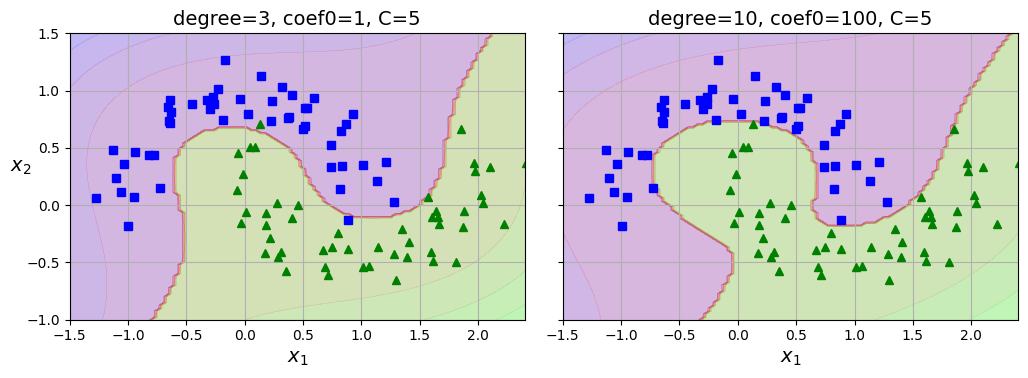

In [13]:
# extra code – this cell generates and saves Figure 5–7

poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=3, coef0=1, C=5")

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=10, coef0=100, C=5")
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

## Similarity Features

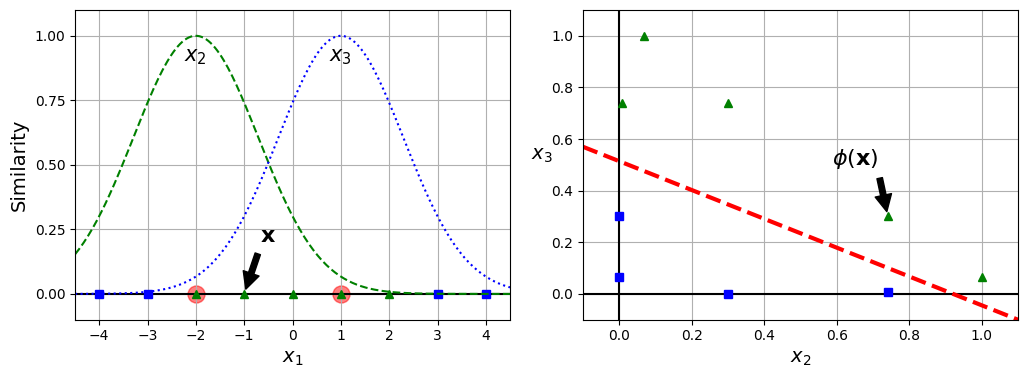

In [14]:
# extra code – this cell generates and saves Figure 5–8

def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel("$x_1$")
plt.ylabel("Similarity")
plt.annotate(
    r'$\mathbf{x}$',
    xy=(X1D[3, 0], 0),
    xytext=(-0.5, 0.20),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=15)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=15)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel("$x_2$")
plt.ylabel("$x_3$  ", rotation=0)
plt.annotate(
    r'$\phi\left(\mathbf{x}\right)$',
    xy=(XK[3, 0], XK[3, 1]),
    xytext=(0.65, 0.50),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

In the above figure, the point x (on the left figure), is transformed to $\phi\left(\mathbf{x}\right)$ (on the right figure), where $x_2$ = exp(-0.3 x $1^2$) $\approx$ 0.74, and $x_3$ = exp(-0.3 x $2^2$) $\approx$ 0.3

Note that x is 1 away from $x_2$ and is 2 away from $x_3$, and the $\gamma$ for both landmark $x_2$ and $x_3$ is 0.3

## Gaussian RBF Kernel

In [15]:
rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=5, C = 0.001)
)
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

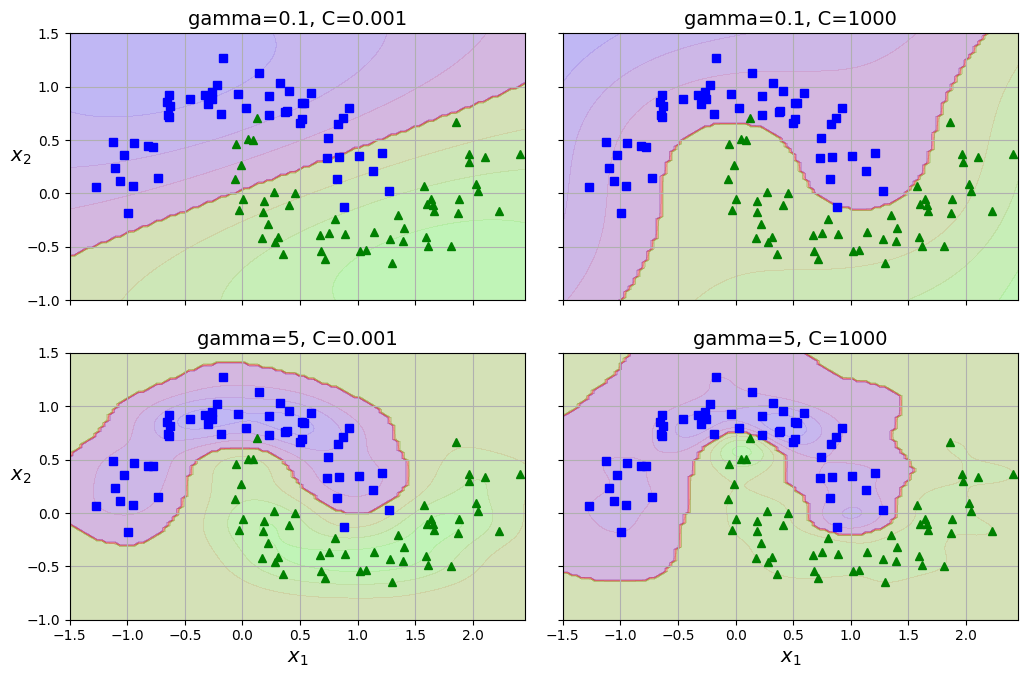

In [16]:
# extra code – this cell generates and saves Figure 5–9

from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(f"gamma={gamma}, C={C}")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

For small gamma, as it makes the bell-shaped curve wider, instances have larger range of influence, hence the decision boundary ends up smoother. <br> 
For big gamma, as it makes the bell-shaped curve narrower, instances have smaller range of influence, hence the decision boundary ends up more irregular.

Hence, gamma acts like a regularization parameter, if dataset is overfit, then reduce gamma, vice versa.

---

In general, the following is the recommended SVM priority
1. LinearSVC
2. SVM with Gaussian RBF Kernel
3. SVM with other kernels (e.g. poly, string (used for classifying text / DNA sequences))

---

## SVM Classes and Computational Complexity

Note that all classes **MUST** be scaled!

LinearSVC -> scales linearly with the number of training instances and features O(mxn)

SVC -> Supports the kernel trick and training time is usually between O($m^2$ x n) and O($m^3$ x n). Hence the algorithm becomes very slow when faced with high dimension data, but scales well with the number of features (especially sparse features)

SGDClassifier -> scales very well, uses the Stochastic GD (allowing for incremental learning and uses little memory [can train a model on a large dataset that does not fit in RAM (i.e. for out-of-core learning)]). O(mxn) complexity.

# SVM Regression

In this case, fit the largest possible street between the two classes while limiting the margin violations.

The margin viiolation is controlled by the hyperparameter $\epsilon$, where the smaller it is the more margin violations (higher support vector) is allowed and vice versa.

In [17]:
from sklearn.svm import LinearSVR

# extra code – these 3 lines generate a simple linear dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

svm_reg = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5, dual=True, random_state=42))
svm_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr',
                 LinearSVR(dual=True, epsilon=0.5, random_state=42))])

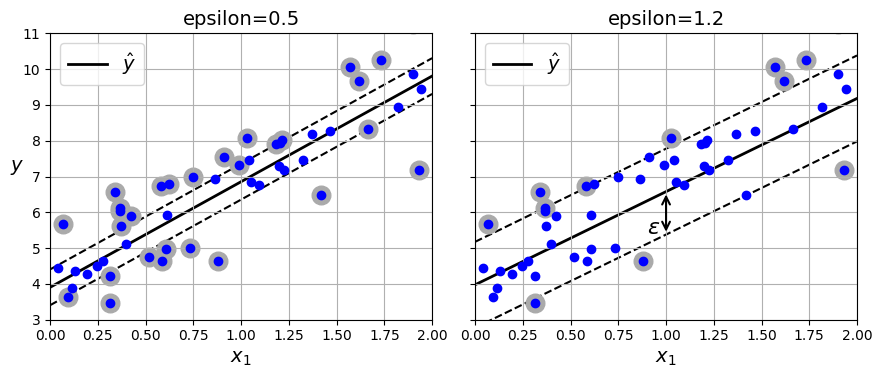

In [18]:
# extra code – this cell generates and saves Figure 5–10

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon
    off_margin = np.abs(y - y_pred) >= epsilon
    return np.argwhere(off_margin)

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    # Plot the SVR and margin line
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
    # Add a outline for support points of the SVR
    plt.scatter(X[svm_reg._support], y[svm_reg._support], s=180,
                facecolors='#AAA', zorder=-1)
    plt.plot(X, y, "bo")
    plt.xlabel("$x_1$")
    plt.legend(loc="upper left")
    plt.axis(axes)

svm_reg2 = make_pipeline(StandardScaler(),
                         LinearSVR(epsilon=1.2, dual=True, random_state=42))
svm_reg2.fit(X, y)

svm_reg._support = find_support_vectors(svm_reg, X, y)
svm_reg2._support = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
# left figure
plt.sca(axes[0])
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()

# right figure
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg2[-1].epsilon}")
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.90, 5.4, r"$\epsilon$", fontsize=16)
plt.grid()
save_fig("svm_regression_plot")

plt.show()

## SVR with Quadratic Polynomial Kernel

In [19]:
from sklearn.svm import SVR

# extra code – these 3 lines generate a simple quadratic dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

svm_poly_reg = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, kernel='poly'))])

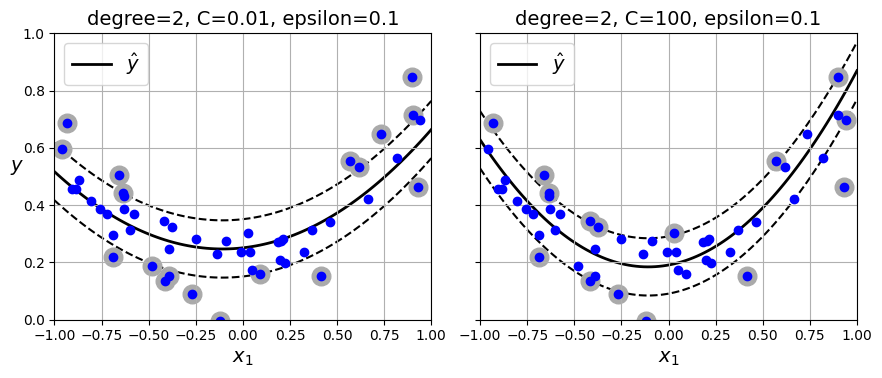

In [20]:
# extra code – this cell generates and saves Figure 5–11

svm_poly_reg2 = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=100))
svm_poly_reg2.fit(X, y)

svm_poly_reg._support = find_support_vectors(svm_poly_reg, X, y)
svm_poly_reg2._support = find_support_vectors(svm_poly_reg2, X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg[-1].degree}, "
          f"C={svm_poly_reg[-1].C}, "
          f"epsilon={svm_poly_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg2[-1].degree}, "
          f"C={svm_poly_reg2[-1].C}, "
          f"epsilon={svm_poly_reg2[-1].epsilon}")
plt.grid()
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

# Under the Hood of Linear SVM Classifiers

The weights for the SVM will need to be small in order for the margins to be big!

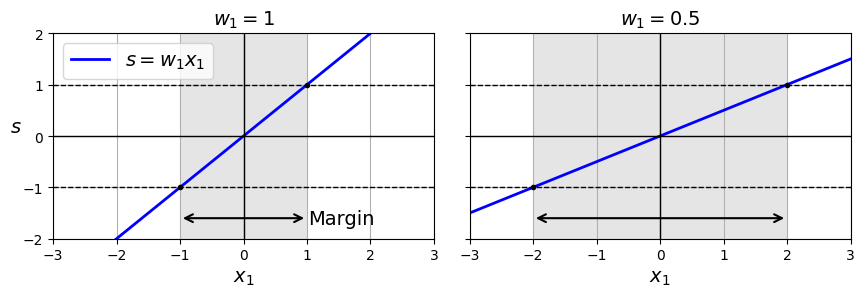

In [21]:
# extra code – this cell generates and saves Figure 5–12

import matplotlib.patches as patches

def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    half_margin = 1 / w

    plt.plot(x1, y, "b-", linewidth=2, label=r"$s = w_1 x_1$")
    plt.axhline(y=0, color='k', linewidth=1)
    plt.axvline(x=0, color='k', linewidth=1)
    rect = patches.Rectangle((-half_margin, -2), 2 * half_margin, 4,
                             edgecolor='none', facecolor='gray', alpha=0.2)
    plt.gca().add_patch(rect)
    plt.plot([-3, 3], [1, 1], "k--", linewidth=1)
    plt.plot([-3, 3], [-1, -1], "k--", linewidth=1)
    plt.plot(half_margin, 1, "k.")
    plt.plot(-half_margin, -1, "k.")
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel("$x_1$")
    if ylabel:
        plt.ylabel("$s$", rotation=0, labelpad=5)
        plt.legend()
        plt.text(1.02, -1.6, "Margin", ha="left", va="center", color="k")

    plt.annotate(
        '', xy=(-half_margin, -1.6), xytext=(half_margin, -1.6),
        arrowprops={'ec': 'k', 'arrowstyle': '<->', 'linewidth': 1.5}
    )
    plt.title(f"$w_1 = {w}$")

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.grid()
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
plt.grid()
save_fig("small_w_large_margin_plot")
plt.show()

To introduce a soft margin objective, we introduce *slack variables* for each instance.

The hard and soft margin problems are both convext quadratic optimization problems that can be solved in different ways such as quadratic programming and gradient descent. For GD, we can minimize the hinge loss / squared hinge loss.

By default, LinearSVC uses squared hinge loss, while SGDClassifier uses the hinge loss. Though both classes let users choose the loss by setting the "loss" parameter to either "hinge" or "squared_hinge".

# The Dual Problem

Essentially, given a constained optimization problem (aka *primal problem*), there is a different but closely related problem (aka *dual problem*) where the solution gives the lower bound to the solution OR is the solution for also the *primal problem* (in the case of SVMs).

During computation of this *dual problem*, the kernel trick can be used to map high dimensional table without actually making the actual transformation

Some common kernels are:
- Linear
- Polynomial
- Gaussian RBF
- Sigmoid

This chapter is math heavy, so refer to the book for further derivation details.

# Exercise

## 1. What is the fundamental idea behind support vector machines?

Finding a hyperplane to separate 2 categories with the widest possible margin / "street" either cleanly or roughly and using that hyperplane to predict newly data.

## 2. What is a support vector

In the context of classification, support vectors are data points that are either on, inside or the other side of the margin of a hyperplane.

Meanwhile in the context of regression, support vectors are data points that are outside the margin of the hyperplane.

## 3. Why is it important to scale the inputs when using SVMs?

If the training set is not scaled, the SVM will tend to neglect small features.

## 4. Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?


The confidence scores can be computed using the decision_function() method.

Showing the probability is possible and can be shown when using SVC class when the $probability$ hyperparameter is set to True and then the predict_proba() and pedict_log_proba() method will be available.

## 5. How can you choose between LinearSVC, SVC and SGDClassifier

LinearSVC -> when using non-kernel linear SVC with high number of data points and features.

SVC -> When using kernel methods and or scaling the data by having more features.

SGDClassifier -> When you want to do out-of-core learning as it only considers one data / training

## 6. Say you've trained an SVM classifier with an RBF kernel, but it seems to underfit the training set. Should you increase or decrease $\gamma$? What about C?

$\gamma$ -> Increase gamma to increase the influence of nearby points.

C -> Increase C to decrease the margin to allow for less data points to be misclassified.

## 7. What does it mean for a model to be *$\epsilon$-insensitive*?

Under the SVM regression method, this refers to where adding more training instances within the margin ($\epsilon$) will not affect the model's prediction.

## 8. What is the point of using the kernel trick?

Allows for scaling of data points to higher dimension (non linear SVM model) without the additional computational complexity of transforming the data points by only computing a modified dot product of a point to other points.

The resulting model is equivalent to mapping the inputs to another space using a nonlinear transformation, then training a linear SVM on the resulting high-dimensional inputs. The kernel trick gives the same result without having to transform the inputs at all.

## 9. Train a LinearSVC on a linearly separable dataset then train an SVC & SGDClassifer on the same dataset. See if all can reproduce similar models.

In [22]:
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# The C hyperparameter is used to determine the size of the margin
# Lower C will allow for larger margins / having more instances supporting the street
svm_pipeline = Pipeline([
    ("scaling", StandardScaler()),
    ("linearsvc", LinearSVC(C = 1, loss="hinge", random_state=42))
])

param = [
    {"linearsvc__C":range(1,11)}
]

grid_search = GridSearchCV(
                svm_pipeline,
                param,
                cv=3,
                scoring="roc_auc"
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('linearsvc',
                                        LinearSVC(C=1, loss='hinge',
                                                  random_state=42))]),
             param_grid=[{'linearsvc__C': range(1, 11)}], scoring='roc_auc')

In [25]:
linearsvc_best = grid_search.best_estimator_

In [26]:
linearsvc_best.named_steps

{'scaling': StandardScaler(),
 'linearsvc': LinearSVC(C=1, loss='hinge', random_state=42)}

In [27]:
from sklearn.metrics import roc_auc_score

y_pred = linearsvc_best.predict(X_test)

roc_auc_score(y_test, y_pred)

np.float64(1.0)

In [28]:
from sklearn.svm import SVC

svc_pipeline = Pipeline([
    ("scaling", StandardScaler()),
    ("svc", SVC(kernel="linear", C = 1, random_state=42))
])

param = [
    {"svc__C":range(1,11)}
]

grid_search_svc = GridSearchCV(
                svc_pipeline,
                param,
                cv=3,
                scoring="roc_auc"
)

grid_search_svc.fit(X_train, y_train)
# poly_kernel_svm_clf = make_pipeline(
#     StandardScaler(),
#     # coef0 controls how much the model is 
#     # influenced by high-degree terms vs low-degree terms
#     SVC(kernel="poly", degree = 3, coef0=1, C = 5)
# )
# poly_kernel_svm_clf.fit(X,y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('svc',
                                        SVC(C=1, kernel='linear',
                                            random_state=42))]),
             param_grid=[{'svc__C': range(1, 11)}], scoring='roc_auc')

In [29]:
svc_best = grid_search_svc.best_estimator_

In [30]:
from sklearn.metrics import roc_auc_score

y_pred = svc_best.predict(X_test)

roc_auc_score(y_test, y_pred)

np.float64(1.0)

In [31]:
from sklearn.linear_model import SGDClassifier

sgdclf_pipeline = Pipeline([
    ("scaling", StandardScaler()),
    ("sgdclf", SGDClassifier(loss="hinge", 
                            alpha = 0.0001,
                            max_iter = 1000, 
                            random_state=42))
])

param = [
    {"sgdclf__alpha":np.linspace(0.0001, 1,20)}
]

grid_search_sgd = GridSearchCV(
                sgdclf_pipeline,
                param,
                cv=3,
                scoring="roc_auc"
)

grid_search_sgd.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('sgdclf',
                                        SGDClassifier(random_state=42))]),
             param_grid=[{'sgdclf__alpha': array([1.00000000e-04, 5.27263158e-02, 1.05352632e-01, 1.57978947e-01,
       2.10605263e-01, 2.63231579e-01, 3.15857895e-01, 3.68484211e-01,
       4.21110526e-01, 4.73736842e-01, 5.26363158e-01, 5.78989474e-01,
       6.31615789e-01, 6.84242105e-01, 7.36868421e-01, 7.89494737e-01,
       8.42121053e-01, 8.94747368e-01, 9.47373684e-01, 1.00000000e+00])}],
             scoring='roc_auc')

In [32]:
sgdclf_best = grid_search_sgd.best_estimator_

In [33]:
sgdclf_best.named_steps.sgdclf.coef_

array([[9.54517084, 9.30350128]])

In [34]:
from sklearn.metrics import roc_auc_score

y_pred = sgdclf_best.predict(X_test)

roc_auc_score(y_test, y_pred)

np.float64(1.0)

In [35]:
y_pred

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0])

In [36]:
y_test

83    1
53    1
70    1
45    0
44    0
39    0
22    0
80    1
10    0
0     0
18    0
30    0
73    1
33    0
90    1
4     0
76    1
77    1
12    0
31    0
Name: target, dtype: int64

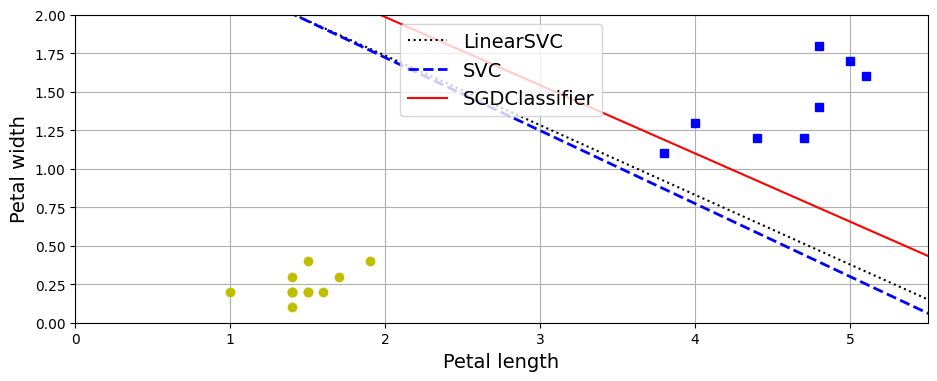

In [37]:
def compute_decision_boundary(model):
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])

lin_line = compute_decision_boundary(linearsvc_best.named_steps.linearsvc)
svc_line = compute_decision_boundary(svc_best.named_steps.svc)
sgd_line = compute_decision_boundary(sgdclf_best.named_steps.sgdclf)

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], "k:", label="LinearSVC")
plt.plot(svc_line[:, 0], svc_line[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(sgd_line[:, 0], sgd_line[:, 1], "r-", label="SGDClassifier")
plt.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1], "bs") # label="Iris versicolor"
plt.plot(X_test[:, 0][y_test==0], X_test[:, 1][y_test==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper center")
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()

## 10. Train an SVM classifier on the wine dataset, which you can load using sklearn.datasets.load_wine(). This dataset contains the chemical analyses of 178 wine samples produced by 3 different cultivators: the goal is to train a classification model capable of predicting the cultivator based on the wine’s chemical analysis. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all three classes. What accuracy can you reach?

In [38]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)

In [39]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [40]:
# check the attributes under wine
dir(wine)

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']

In [41]:
X, y = wine.data, wine.target

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

In [43]:
svm_classifier = SVC(
    kernel='rbf',  # 'linear', 'poly', 'rbf', 'sigmoid', etc.
    C=1.0,         # Regularization parameter
    gamma='scale',  # Kernel coefficient ('scale', 'auto', or float)
    decision_function_shape='ovr'  # 'ovr' (One-vs-Rest) or 'ovo' (One-vs-One)
)

In [44]:
scaler = StandardScaler()
X_train_transform = scaler.fit_transform(X_train)

In [45]:
svm_classifier.fit(X_train_transform, y_train)

SVC()

In [46]:
X_test_transform = scaler.transform(X_test)
y_pred = svm_classifier.predict(X_test_transform)

In [47]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

1.0

In [48]:
y_pred

array([0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 0, 2, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 2, 2, 2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0])

### From textbook solution

In [49]:
from sklearn.model_selection import cross_val_score

svm_clf = make_pipeline(StandardScaler(), SVC(random_state=42))

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

param_distrib = {
    "svc__gamma": loguniform(0.001, 0.1),
    "svc__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter=100, cv=5,
                                   random_state=42)
rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=np.float64(2.560186404424365),
                     gamma=np.float64(0.002051110418843397),
                     random_state=42))])

In [50]:
rnd_search_cv.best_score_

np.float64(0.9857142857142858)

In [51]:
rnd_search_cv.score(X_test, y_test)

1.0

## 11. Train and fine-tune an SVM regressor on the California housing dataset. You can use the original dataset rather than the tweaked version we used in Chapter 2, which you can load using sklearn.datasets.fetch_california_housing(). The targets represent hundreds of thousands of dollars. Since there are over 20,000 instances, SVMs can be slow, so for hyperparameter tuning you should use far fewer instances (e.g., 2,000) to test many more hyperparameter combinations. What is your best model’s RMSE?

In [52]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing.data
y = housing.target

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [77]:
from sklearn.svm import LinearSVR

svm_reg = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5, 
                                  dual=True, 
                                  random_state=42,
                                  max_iter=10000))

param_distrib = {
    "linearsvr__epsilon": [0.001, 0.01, 0.1, 1, 10],
    "linearsvr__C": uniform(1, 10)
}

rnd_search_cv = RandomizedSearchCV(svm_reg, param_distrib, n_iter=100, cv=5,
                                   random_state=42)
rnd_search_cv.fit(X_train[:2000], y_train[:2000])
rnd_search_cv.best_estimator_

# svm_reg = make_pipeline(StandardScaler(),
#                         LinearSVR(epsilon=0.5, dual=True, random_state=42))
# svm_reg.fit(X_train, y_train)

/Users/kevinkyhalim/ML_repo/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kevinkyhalim/ML_repo/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kevinkyhalim/ML_repo/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kevinkyhalim/ML_repo/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kevinkyhalim/ML_repo/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kevinkyhalim/ML_repo/.venv/lib/py

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr',
                 LinearSVR(C=np.float64(7.118528947223795), dual=True,
                           epsilon=0.01, max_iter=10000, random_state=42))])

In [78]:
rnd_search_cv.score(X_test, y_test)

0.5042882542412166

In [79]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test)

In [80]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_test, y_pred)

0.8059684375096706

Using SVR

In [82]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

svm_reg = make_pipeline(StandardScaler(), SVR())

param_distrib = {
    # is there a reason why we are using the loguniform function to determine gamma?
    "svr__gamma": loguniform(0.001, 0.1),
    "svr__C": uniform(1, 10)
}
rnd_search_cv_2 = RandomizedSearchCV(svm_reg, param_distrib,
                                   n_iter=100, cv=3, random_state=42)
# train the first 2000 values to save time in this demonstration
rnd_search_cv_2.fit(X_train[:2000], y_train[:2000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=100,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x301bcbef0>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x301bcba40>},
                   random_state=42)

In [83]:
rnd_search_cv_2.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr',
                 SVR(C=np.float64(4.63629602379294),
                     gamma=np.float64(0.08781408196485979)))])

In [84]:
-cross_val_score(rnd_search_cv_2.best_estimator_, X_train, y_train,
                 scoring="neg_root_mean_squared_error")

array([0.58835834, 0.57467604, 0.58085519, 0.57110118, 0.59853257])

In [85]:
y_pred = rnd_search_cv_2.best_estimator_.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
rmse

0.5854802170664868

## SVR with Quadratic Polynomial Kernel

In [ ]:
from sklearn.svm import SVR

# extra code – these 3 lines generate a simple quadratic dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

svm_poly_reg = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, kernel='poly'))])

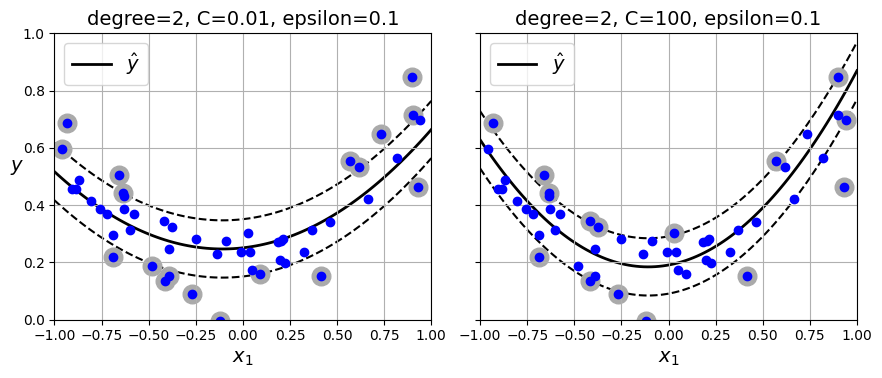

In [ ]:
# extra code – this cell generates and saves Figure 5–11

svm_poly_reg2 = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=100))
svm_poly_reg2.fit(X, y)

svm_poly_reg._support = find_support_vectors(svm_poly_reg, X, y)
svm_poly_reg2._support = find_support_vectors(svm_poly_reg2, X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg[-1].degree}, "
          f"C={svm_poly_reg[-1].C}, "
          f"epsilon={svm_poly_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg2[-1].degree}, "
          f"C={svm_poly_reg2[-1].C}, "
          f"epsilon={svm_poly_reg2[-1].epsilon}")
plt.grid()
save_fig("svm_with_polynomial_kernel_plot")
plt.show()